In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

# raw_data = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/boston.csv', header=None)
raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/boston.csv',header=None)

data_rows = np.reshape(raw_data.to_numpy(), (506,14))
data = data_rows[:,:13]
target = data_rows[:,13]

# normalize input features to zero-mean and unit-variance
data = (data-np.mean(data, axis=0))/np.std(data, axis=0) 
print(raw_data)

print(data.shape)
print(target.shape)
data

      0     1     2     3      4      5     6     7     8      9     ...  \
0  0.00632  18.0  2.31     0  0.538  6.575  65.2  4.09     1  296.0  ...   

    7074  7075  7076   7077  7078   7079  7080   7081  7082  7083  
0  0.573  6.03  80.8  2.505     1  273.0  21.0  396.9  7.88  11.9  

[1 rows x 7084 columns]
(506, 13)
(506,)


array([[-0.41978194,  0.28482986, -1.2879095 , ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.59338101, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.59338101, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.11573841, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.66905833]])

# Closed form of ridge regression. Example # 1

In [3]:
def closed_form_reg_solution(X,y,lamda): 
    '''Closed form solution for ridge regression'''
    m,n = X.shape
    print(m,n)
    I = np.eye((n))
    inr=np.linalg.inv(X.T @ X + lamda * I)@ X.T @ y
    return inr
    # return (inr @ X.T @ y)[:,0]
data_wb = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))
lamda=1
sol=closed_form_reg_solution(data_wb,target,lamda)   
sol 
predict = data_wb @ sol 
error = (np.sum((predict - target)*(predict - target)))/data.shape[0] 

# error=error + lamda*sol
print(f'mean square error for the closed-form solution: {error:.3f}')

506 14
mean square error for the closed-form solution: 21.898


# closed from linear regression

In [4]:
data_wb = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))



# refer to the closed-form solution
w = np.linalg.inv(data_wb.T @ data_wb) @ data_wb.T @ target
print(w)
# calculate the mean square error in the training set
predict = data_wb @ w 
error = np.sum((predict - target)*(predict - target))/data.shape[0]

print(f'mean square error for the closed-form solution: {error:.3f}')

[-9.28146064e-01  1.08156863e+00  1.40899997e-01  6.81739725e-01
 -2.05671827e+00  2.67423017e+00  1.94660717e-02 -3.10404426e+00
  2.66221764e+00 -2.07678168e+00 -2.06060666e+00  8.49268418e-01
 -3.74362713e+00  2.25328063e+01]
mean square error for the closed-form solution: 21.895


# Gradient descent linear regeression

In [5]:
# solve linear regression using gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: input features; y[N]: output targets; op: hyper-parameters for optimzer 
def linear_regression_gd(X, y, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errors = np.zeros(op.max_epochs)
  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch 

      w -= lr * w_grad / X_batch.shape[0]

    diff = X @ w - y  # prediction difference
    errors[epoch] = np.sum(diff*diff)/n
    lr *= op.annealing_rate
    #print(f'epoch={epoch}: the mean square error is {errors[epoch]}')

  return w, errors

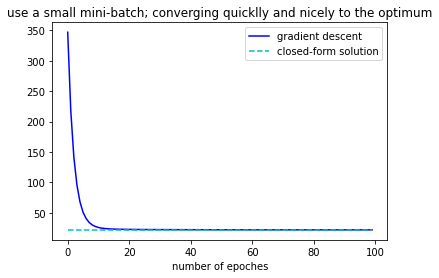

In [6]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=2, max_epochs=100)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('use a small mini-batch; converging quicklly and nicely to the optimum')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

## Ridge gradien descent

In [7]:
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs,lambdaa):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs
    self.lambdaa=lambdaa

# X[N,d]: input features; y[N]: output targets; op: hyper-parameters for optimzer 
def linear_regression_gd(X, y, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization
  
  lr = op.lr
  lambdaa=op.lambdaa
  lam=np.ones(14)*10
  print(lam)
  errors = np.zeros(op.max_epochs)
  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]
    
      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @  X_batch @ w -  X_batch.T  @  y_batch - w*lambdaa
      # np.dot(w,lambaa)

      w -= lr * w_grad / X_batch.shape[0]

    diff = X @ w - y  # prediction difference
    errors[epoch] = np.sum(diff*diff)/n
    lr *= op.annealing_rate
    #print(f'epoch={epoch}: the mean square error is {errors[epoch]}')

  return w, errors


[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


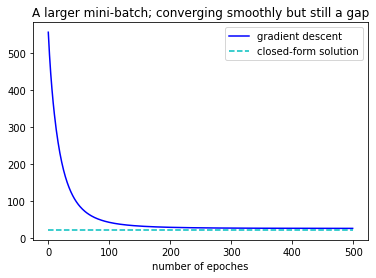

In [8]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=20, max_epochs=500,lambdaa=0.1)

w, errors = linear_regression_gd(data_wb, target, op)
# w,errors =gradient_descent_reg(data_wb,target,np.zeros([506,14]),0.0005,10,1000)
plt.title('A larger mini-batch; converging smoothly but still a gap')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

# Lasso regression

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_wb,target, test_size=0.3, random_state=10)

In [10]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 26.18
MSE test set 34.85


# Expample # 2.2

In [ ]:
!pip install python_mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mnist import MNIST
import numpy as np

mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_label = np.array(test_label, dtype='short')

#add small random noise to avoid matrix singularity
train_data += np.random.normal(0,0.0001,train_data.shape) 

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [ ]:
# prepare digits '3' and '8' for linear regression

digit_train_index = np.logical_or(train_label == 3, train_label == 8)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 3, test_label == 8)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# add a constant column of '1' to accomodate the bias (see the margin note on page 107)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype)))

# convert labels: '3' => -1, '8' => +1
CUTOFF = 5 # any number between '3' and '8'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

print(X_train.shape)
print(y_train)

print(X_test.shape)
print(y_test)

(11982, 785)
[-1 -1 -1 ...  1 -1  1]
(1984, 785)
[-1 -1 -1 ... -1  1 -1]


# linear regression closed form



In [ ]:
# use the closed-form solution

# refer to the closed-form solution, i.e. Eq.(6.9) on page 112
w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# calculate the mean square error and classification accuracy on the training set
predict = X_train @ w 
error = np.sum((predict - y_train)*(predict - y_train))/X_train.shape[0]
print(f'mean square error on training data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_train))/y_train.size*100.0
print(f'classification accuracy on training data for the closed-form solution: {accuracy:.2f}%')

# calculate the mean square error and classification accuracy on the test set
predict = X_test @ w 
error = np.sum((predict - y_test)*(predict - y_test))/X_test.shape[0]
print(f'mean square error on test data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_test))/y_test.size*100.0
print(f'classification accuracy on test data for the closed-form solution: {accuracy:.2f}%')

mean square error on training data for the closed-form solution: 0.19526
classification accuracy on training data for the closed-form solution: 97.10%
mean square error on test data for the closed-form solution: 1.24126
classification accuracy on test data for the closed-form solution: 95.87%


# Ridge regression closed form


In [ ]:
def closed_form_reg_solution(X,y,lamda): 
    '''Closed form solution for ridge regression'''
    m,n = X.shape
    print(m,n)
    I = np.eye((n))
    inr=np.linalg.inv(X.T @ X + lamda * I)@ X.T @ y
    return inr
    # return (inr @ X.T @ y)[:,0]

lamda=1
w=closed_form_reg_solution(X_train,y_train,lamda)
predict = X_train @ w 
error = np.sum((predict - y_train)*(predict - y_train))/X_train.shape[0]
print(f'mean square error on training data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_train))/y_train.size*100.0
print(f'classification accuracy on training data for the closed-form solution: {accuracy:.2f}%')

# calculate the mean square error and classification accuracy on the test set
predict = X_test @ w 
error = np.sum((predict - y_test)*(predict - y_test))/X_test.shape[0]
print(f'mean square error on test data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_test))/y_test.size*100.0
print(f'classification accuracy on test data for the closed-form solution: {accuracy:.2f}%')

11982 785
mean square error on training data for the closed-form solution: 0.20013
classification accuracy on training data for the closed-form solution: 96.79%
mean square error on test data for the closed-form solution: 0.22012
classification accuracy on test data for the closed-form solution: 95.97%


# Linear regression gradient descent

In [ ]:
 # solve linear regression using gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: training features; y[N]: training targets; 
# X2[N,d]: test features; y2[N]: test targets;  
# op: hyper-parameters for optimzer 
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def linear_regression_gd2(X, y, X2, y2, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch 

      w -= lr * w_grad / X_batch.shape[0] 

    # for learning curve C
    diff = X @ w - y  # prediction difference
    errorsC[epoch] = np.sum(diff*diff)/n   

    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size 

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errorsC[epoch]:.3f} ({errorsA[epoch]:.3f},{errorsB[epoch]:.3f})')

  return w, errorsA, errorsB, errorsC

epoch=0: the mean square error is 0.398 (0.912,0.920)
epoch=1: the mean square error is 0.309 (0.929,0.941)
epoch=2: the mean square error is 0.279 (0.939,0.951)
epoch=3: the mean square error is 0.263 (0.944,0.957)
epoch=4: the mean square error is 0.254 (0.948,0.958)
epoch=5: the mean square error is 0.248 (0.951,0.961)
epoch=6: the mean square error is 0.244 (0.952,0.963)
epoch=7: the mean square error is 0.240 (0.954,0.964)
epoch=8: the mean square error is 0.237 (0.955,0.964)
epoch=9: the mean square error is 0.236 (0.956,0.963)
epoch=10: the mean square error is 0.234 (0.957,0.964)
epoch=11: the mean square error is 0.232 (0.957,0.965)
epoch=12: the mean square error is 0.231 (0.958,0.963)
epoch=13: the mean square error is 0.230 (0.958,0.963)
epoch=14: the mean square error is 0.229 (0.959,0.964)
epoch=15: the mean square error is 0.228 (0.960,0.964)
epoch=16: the mean square error is 0.227 (0.960,0.964)
epoch=17: the mean square error is 0.226 (0.959,0.963)
epoch=18: the mean s

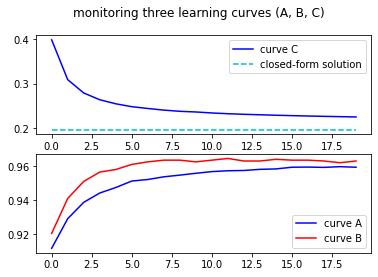

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=50, max_epochs=20)

w, A, B, C = linear_regression_gd2(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

# Ridge regression using gradient descent

In [ ]:
 # solve ridge regression using gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs,lamda):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs
    self.lamda = lamda
# X[N,d]: training features; y[N]: training targets; 
# X2[N,d]: test features; y2[N]: test targets;  
# op: hyper-parameters for optimzer 
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def linear_regression_gd2(X, y, X2, y2, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  lambdaa=op.lamda
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
    
      w_grad = X_batch.T @  X_batch @ w -  X_batch.T  @  y_batch - w*lambdaa
      w -= lr * w_grad / X_batch.shape[0] 

    # for learning curve C
    diff = X @ w - y  # prediction difference
    errorsC[epoch] = np.sum(diff*diff)/n   

    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size 

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errorsC[epoch]:.3f} ({errorsA[epoch]:.3f},{errorsB[epoch]:.3f})')

  return w, errorsA, errorsB, errorsC

epoch=0: the mean square error is 0.398 (0.913,0.920)
epoch=1: the mean square error is 0.308 (0.929,0.943)
epoch=2: the mean square error is 0.278 (0.939,0.952)
epoch=3: the mean square error is 0.263 (0.944,0.957)
epoch=4: the mean square error is 0.254 (0.948,0.958)
epoch=5: the mean square error is 0.248 (0.951,0.959)
epoch=6: the mean square error is 0.243 (0.953,0.962)
epoch=7: the mean square error is 0.240 (0.955,0.963)
epoch=8: the mean square error is 0.237 (0.955,0.963)
epoch=9: the mean square error is 0.235 (0.956,0.964)
epoch=10: the mean square error is 0.233 (0.957,0.964)
epoch=11: the mean square error is 0.232 (0.958,0.964)
epoch=12: the mean square error is 0.230 (0.958,0.964)
epoch=13: the mean square error is 0.229 (0.958,0.963)
epoch=14: the mean square error is 0.228 (0.959,0.963)
epoch=15: the mean square error is 0.227 (0.960,0.964)
epoch=16: the mean square error is 0.226 (0.959,0.964)
epoch=17: the mean square error is 0.226 (0.960,0.965)
epoch=18: the mean s

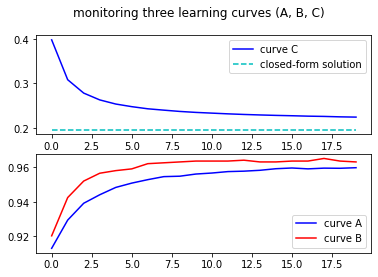

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=50, max_epochs=20,lamda=0.5)

w, A, B, C = linear_regression_gd2(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

# Lasso regression example # 2.2


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 1.0
MSE test set 1.0
